In [1]:
import Pkg; Pkg.activate(".")

  Activating project at `~/mit/InverseGraphics/notebooks/2d_slam`


In [3]:
import Pkg; Pkg.develop(path="./dev/GLRenderer")
import Pkg; Pkg.add(["Revise","PoseComposition", "Rotations","Plots","Images","Gen","Distributions","LinearAlgebra"])

   Resolving package versions...
  No Changes to `C:\Users\DJ Myylo\Desktop\julia_exercises\Project.toml`
  No Changes to `C:\Users\DJ Myylo\Desktop\julia_exercises\Manifest.toml`
    Updating registry at `C:\Users\DJ Myylo\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\DJ Myylo\Desktop\julia_exercises\Project.toml`
  No Changes to `C:\Users\DJ Myylo\Desktop\julia_exercises\Manifest.toml`


In [2]:
import Revise
import GLRenderer
import PoseComposition
import Rotations
import Plots
import Images
import Gen
import Distributions
import LinearAlgebra

# arijit: renaming the libraries below to their abbreviated form (equivalent to 'import Plots as PL' in python style)
I = Images
PL = Plots

R = Rotations
P = PoseComposition
GL = GLRenderer

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a]
│   exception = Required dependency libass_jll [0ac62f75-1d6f-5e53-bd7c-93b484bb37c0] failed to load from a cache file.
└ @ Base loading.jl:1132
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
│   exception = ErrorException("Required dependency libass_jll [0ac62f75-1d6f-5e53-bd7c-93b484bb37c0] failed to load from a cache file.")
└ @ Base loading.jl:1132
┌ Info: Precompiling FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a]
└ @ Base loading.jl:1423
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for FFMPEG [c87230d0-a227-11e9-1b43-d7ebe4e7570a]
│   exception = ErrorException("Required dependency libass_jll [0ac62f75-1d6f-5e53-bd7c-93b484bb37c0] fai

GLRenderer

In [3]:
Revise.errors()
Revise.revise()

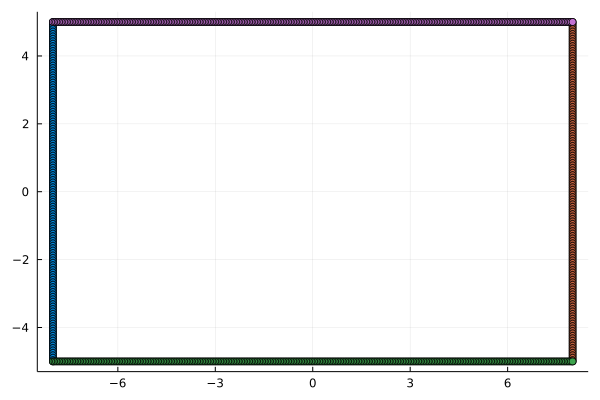

In [4]:
# Set room dimensions
# arijit: rectangular room (note to self: play around with room dimensions, assume units are in metres)
room_width_bounds = (-8.0, 8.0)
room_height_bounds = (-5.0, 5.0)

# Create point clouds corresponding to the 4 walls of the room
resolution = 0.1 # arijit: this value is the resolution normalised by 2.0. 
# So a value of 0.1 would mean that each point on the wall is separated by 0.1/2.0 ~= 0.05m
left_wall = []
right_wall = []
front_wall = []
back_wall = []
# arijit: recall Julia uses 1-indexing unlike Python and C/C++
for z in room_height_bounds[1]:resolution/2.0:room_height_bounds[2]
    # arijit: insert [x,y,z] coordinates into left and right walls. X is horizontal and Z is vertical
    push!(left_wall, [room_width_bounds[1], 0.0, z])
    push!(right_wall, [room_width_bounds[2], 0.0, z])
end
for x in room_width_bounds[1]:resolution/2.0:room_width_bounds[2]
    # arijit: similarly, insert [x,y,z] coordinates into top and bottom walls
    push!(front_wall, [x, 0.0, room_height_bounds[1]])
    push!(back_wall, [x, 0.0, room_height_bounds[2]])
end

# arijit: horizontal concat, so the data is represented as [x_1 x_2 .. x_n; y_1 y_2 .. y_n; z_1 z_2 .. z_n]
#  notice that y is always 0, as this is a 2D problem
left_wall = hcat(left_wall...)
right_wall = hcat(right_wall...)
front_wall = hcat(front_wall...)
back_wall = hcat(back_wall...)

# Visualize the walls
# arijit: horizontal concat again to put all 4 walls in the same representation for room_cloud
room_cloud = hcat(left_wall,right_wall,front_wall,back_wall)
# arijit: (advice from Nishad --> visualisation is very impt in prob comp methods), so scatter plot is used to visualise point cloud
PL.scatter(left_wall[1,:], left_wall[3,:],label="")
PL.scatter!(right_wall[1,:], right_wall[3,:],label="")
PL.scatter!(front_wall[1,:], front_wall[3,:],label="")
PL.scatter!(back_wall[1,:], back_wall[3,:],label="")

In [6]:
# Convert the point clouds to meshes that can then be rendered using our RGBD renderer.
# arijit: from what I see, the GL.mesh method takes the voxelized walls and makes a mesh)
m1 = GL.mesh_from_voxelized_cloud(GL.voxelize(left_wall, resolution), resolution);
m2 = GL.mesh_from_voxelized_cloud(GL.voxelize(right_wall, resolution), resolution);
m3 = GL.mesh_from_voxelized_cloud(GL.voxelize(front_wall, resolution), resolution);
m4 = GL.mesh_from_voxelized_cloud(GL.voxelize(back_wall, resolution), resolution);

gl_version_for_shaders = "410"
true


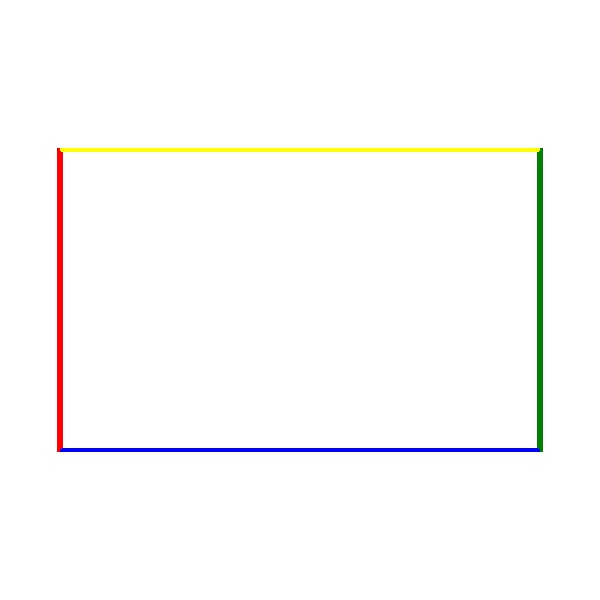

In [7]:
# Create renderer
renderer = GL.setup_renderer(GL.CameraIntrinsics(
    600, 600,
    300.0, 300.0,
    300.0,300.0,
    0.1, 60.0
), GL.RGBBasicMode())

# Add 4 wall objects.
GL.load_object!(renderer, m1)
GL.load_object!(renderer, m2)
GL.load_object!(renderer, m3)
GL.load_object!(renderer, m4)

# Set 4 wall colors
# arijit: note to self --> play around with the wall colours (same colours or different)
wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
# wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

# Render a top view so you can see what the room looks like.
rgb, depth = GL.gl_render(
    renderer,
    [1,2,3,4],
    [P.IDENTITY_POSE, P.IDENTITY_POSE,P.IDENTITY_POSE,P.IDENTITY_POSE],
    P.Pose([0.0, -10.0, 0.0], R.RotX(-pi/2))
    ; colors=wall_colors
)

GL.view_rgb_image(rgb)

In [8]:
# Since we are doing 2D SLAM, the agent only needs to look at a small slice of the world.
# So, we make the height of the rendered image 1
camera_intrinsics = GL.CameraIntrinsics(
    14, 1, # arijit: note that the 14 here refers to the number of horizontal slices observed by the camera
    # this is one crucial parameter to test
    5.0, 1.0,
    7.0, 0.5,
    0.1, 20.0
)
renderer = GL.setup_renderer(camera_intrinsics, GL.RGBBasicMode())
GL.load_object!(renderer, m1)
GL.load_object!(renderer, m2)
GL.load_object!(renderer, m3)
GL.load_object!(renderer, m4)

# this is a deterministic pose set for the camera at [0,0,0] 45 degrees anticlockwise from the z axis
cam_pose = P.Pose(zeros(3),R.RotY(-pi/4+ 0.0))
# cam_pose = P.Pose(zeros(3),R.RotY(pi/2 - 0.558599315))

@time rgb, depth = GL.gl_render(
    renderer, 
    [1,2,3,4], [P.IDENTITY_POSE, P.IDENTITY_POSE,P.IDENTITY_POSE,P.IDENTITY_POSE],
    cam_pose;
    colors=wall_colors
)
# color = map(argmin, eachcol(vcat([I.colordiff.(img, c) for c in wall_colors]...)))
GL.view_rgb_image(rgb)

gl_version_for_shaders = "410"
true
  0.069481 seconds (112.59 k allocations: 6.115 MiB, 79.32% compilation time)


In [9]:
# arijit: PoseUniform is a subtype of a Gen Distribution object of type P.Pose
struct PoseUniform <: Gen.Distribution{P.Pose} end
const pose_uniform = PoseUniform()
# arijit: randomly sample a (x,z,hd) coordinate uniformly across the map with the specified bounds
# arijit: this is defining the random sample method on the abstract distribution struct of PoseUniform
function Gen.random(::PoseUniform, bounds_x, bounds_z)
    x = rand(Distributions.Uniform(bounds_x...))
    z = rand(Distributions.Uniform(bounds_z...))
    # arijit: should this really be -2pi to pi? should it not be -pi to pi?
    hd = rand(Distributions.Uniform(-2*pi, 2*pi))
    P.Pose([x, 0.0, z], R.RotY(hd))
end

# arijit: function to get the sum of the logpdf of each element in the pose on the PoseUniform data struct
function Gen.logpdf(::PoseUniform, pose::P.Pose, bounds_x, bounds_z)
    (
        Gen.logpdf(Gen.uniform, pose.pos[1], bounds_x...) +
        Gen.logpdf(Gen.uniform, pose.pos[3], bounds_z...) +
        Gen.logpdf(Gen.uniform, R.RotY(pose.orientation).theta, -2*pi, 2*pi)
    )   
end

# arijit: likelihood functions for color and depth (p(observation | parameters))
# arijit: color also has a custom Gen distribution which can be seen as an array of real numbers (perhaps [R,G,B]?)
struct ColorLikelihood <: Gen.Distribution{Array{<:Real}} end
const color_likelihood = ColorLikelihood()
# arijit: custom random method for the color likelihood function, to check the likelihood of that colour
function Gen.random(::ColorLikelihood, color, var)
    (x -> Gen.random(Gen.normal, x, var)).(color) # dot operation
end
function Gen.logpdf(::ColorLikelihood, obs_color, color, var)
    sum((x -> Gen.logpdf(Gen.normal, x, 0.0, var)).(obs_color .- color))    
end

struct DepthLikelihood <: Gen.Distribution{Array{<:Real}} end
const depth_likelihood = DepthLikelihood()
function Gen.random(::DepthLikelihood, depth, var)
    (x -> Gen.random(Gen.normal, x, var)).(depth)
end
function Gen.logpdf(::DepthLikelihood, obs_depth, depth, var)
    sum((x -> Gen.logpdf(Gen.normal, x, 0.0, var)).(obs_depth .- depth))    
end

In [10]:
room_bounds_uniform_params = [room_width_bounds[1] room_width_bounds[2];room_height_bounds[1] room_height_bounds[2]]

2×2 Matrix{Float64}:
 -8.0  8.0
 -5.0  5.0

In [41]:
# arijit: generative model for the 2d slam
@Gen.gen function slam_model(room_width_bounds, room_height_bounds, wall_colors, depth_likelihood_variance)
    # arijit: syntactic sugar version of sampling a uniform pose in the 2D map
    pose ~ pose_uniform(room_width_bounds, room_height_bounds)
    
    # arijit: then render the sampled pose into the GL renderer
    # rgb has datatype of 4 x 14 (most likely RGBA?) for each of the 14 points
    # depth is 1 x 14 array of depth
    rgb, depth = GL.gl_render(renderer, 
        [1,2,3,4], [P.IDENTITY_POSE, P.IDENTITY_POSE,P.IDENTITY_POSE,P.IDENTITY_POSE], pose;
        colors=wall_colors
    )
    #############################################################################
    # arijit: sample the likelihoods for depth and color
    # arijit: the variance here is analogous to sensor noise in real-robots
    #############################################################################
    depth_obs ~ depth_likelihood(depth, depth_likelihood_variance)
    rgb_obs ~ color_likelihood(rgb, 0.01) # can play around with this variance

    return (pose=pose, rgb=rgb, depth=depth, depth_obs=depth_obs, rgb_obs=rgb_obs)
end

# arijit: addresses for sampled rgb_obs, depth_obs and pose (based on robot sensor)
sense_rgb_addr() = :rgb_obs
sense_depth_addr() = :depth_obs
pose_addr() = :pose

# arijit: getter functions using the trace of the simulation
get_pose(tr) = tr[pose_addr()]
get_gen_depth(tr) = Gen.get_retval(tr).depth # arijit: i believe this is the ground truth
get_gen_rgb(tr) = Gen.get_retval(tr).rgb # arijit: i believe this is the ground truth
get_sense_rgb(tr) = tr[sense_rgb_addr()]
get_sense_depth(tr) = tr[sense_depth_addr()]
get_wall_colors(tr) = Gen.get_args(tr)[3]

# arijit: I'm unsure what this macro is doing, even after searching in the docs
Gen.@load_generated_functions

# arijit: the 5 functions below were created by the creator of this notebook to help me visualise
function viz_env(;wall_colors=nothing)
    width = 5
    if isnothing(wall_colors)
        c = I.colorant"blue"
        PL.plot!([room_width_bounds[1],room_width_bounds[1]],
                [room_height_bounds[1],room_height_bounds[2]], linewidth=width,
            color=c,label=false)
        PL.plot!([room_width_bounds[2],room_width_bounds[2]],
                [room_height_bounds[1],room_height_bounds[2]], linewidth=width,
            color=c,label=false)
        PL.plot!([room_width_bounds[1],room_width_bounds[2]],
                [room_height_bounds[1],room_height_bounds[1]], linewidth=width,
            color=c,label=false)
        PL.plot!([room_width_bounds[1],room_width_bounds[2]],
                [room_height_bounds[2],room_height_bounds[2]], linewidth=width,
            color=c,label=false)
    else
        PL.plot!([room_width_bounds[1],room_width_bounds[1]],
                [room_height_bounds[1],room_height_bounds[2]], linewidth=width,
            color=wall_colors[1],label=false)
        PL.plot!([room_width_bounds[2],room_width_bounds[2]],
                [room_height_bounds[1],room_height_bounds[2]], linewidth=width,
            color=wall_colors[2],label=false)
        PL.plot!([room_width_bounds[1],room_width_bounds[2]],
                [room_height_bounds[1],room_height_bounds[1]], linewidth=width,
            color=wall_colors[3],label=false)
        PL.plot!([room_width_bounds[1],room_width_bounds[2]],
                [room_height_bounds[2],room_height_bounds[2]], linewidth=width,
            color=wall_colors[4],label=false)
        
    end
end

function viz_pose(pose; alpha=1.0)
    pos = pose.pos
    PL.scatter!([pos[1]], [pos[3]],color=:red,alpha=alpha,label=false)

    direction = pose.orientation * [0.0, 0.0, 1.0]
    PL.plot!([pos[1], pos[1]+direction[1]],
             [pos[3], pos[3]+direction[3]],
             arrow=true,color=:black, linewidth=2, alpha=alpha,label=false)
end

function viz_obs(tr)
    pose = get_pose(tr)
    depth = get_gen_depth(tr)
    sense = get_sense_depth(tr)
    
    cloud = GL.depth_image_to_point_cloud(depth, camera_intrinsics)
    cloud = GL.move_points_to_frame_b(cloud, pose)
    PL.scatter!(cloud[1,:], cloud[3,:], aspect_ratio=:equal, label=false, color=I.colorant"green")
    
    cloud = GL.depth_image_to_point_cloud(reshape(sense,(camera_intrinsics.height, camera_intrinsics.width)), camera_intrinsics)
    cloud = GL.move_points_to_frame_b(cloud, pose)
    PL.scatter!(cloud[1,:], cloud[3,:], aspect_ratio=:equal, label=false, color=I.colorant"cyan")
end
    
function viz_trace(tr)
    PL.plot()
    viz_env(;wall_colors=get_wall_colors(tr))
    viz_pose(get_pose(tr))
    viz_obs(tr)
    PL.plot!()
end

function viz_corner(corner_pose)
    PL.scatter!([corner_pose.pos[1]], [corner_pose.pos[3]], label=false)
    pos = corner_pose.pos
    direction = corner_pose.orientation * [4.0, 0.0, 0.0]
    PL.plot!([pos[1], pos[1]+direction[1]],[pos[3], pos[3]+direction[3]],arrow=true,color=:red,linewidth=2, label=false)
end

viz_corner (generic function with 1 method)

# Part 1 - Enumeration

180.2255149473248

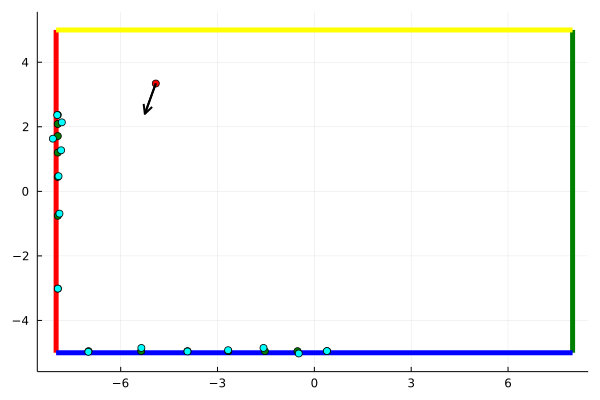

In [24]:
# Generate ground truth data from the model. The observations in this trace will be what we condition on
# and attempt to infer the pose.

wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
# wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]
depth_likelihood_variance = 0.1
# arijit: note that this is where we insert the variance of the depth. the rgb variance is inside the @gen model function
trace_ground_truth, w = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, depth_likelihood_variance));
print(Gen.get_score(trace_ground_truth))
viz_trace(trace_ground_truth)

In [25]:
GL.view_rgb_image(trace_ground_truth[sense_rgb_addr()])

In [26]:
get_pose(trace_ground_truth)

Pose⟨pos=[-4.912712765127276, 0.0, 3.340210490200983], orientation=(w=0.1720876060233497, x=-0.0, y=-0.9850816493332686, z=-0.0)⟩

size(candidate_poses) = (16, 10)


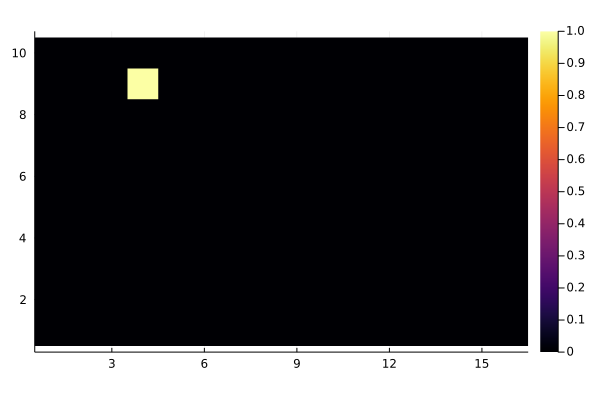

In [27]:
# first I separate the map into equal sized grids (ratio of width:height is constant)
x_grids = 16
z_grids = 10
hd_grids = 30
x_size = room_width_bounds[2] - room_width_bounds[1]
z_size = room_height_bounds[2] - room_height_bounds[1]

# 1. Sweep over candidate poses
# I loop through all grid cells and create a pose object for each cell
candidate_poses = [
    P.Pose([(x/(x_grids+1))*x_size + room_width_bounds[1], 0.0, (z/(z_grids+1))*z_size + 
            room_height_bounds[1]], R.RotY(0)) for x=1:x_grids, z=1:z_grids
];

@show size(candidate_poses)

# 2. Create traces for each of the candidate poses under the generative model. Hint (use Gen.update)
######################################################################################################
# I was not entirely sure of the exact steps for this step. After I looked at the instructions.pdf
# I realised that the end goal was to create a posterior over the 2D location (based on the expected figure)
# However, that figure did not convey information about the orientation. Using this, I came up with my interpretation
# of the problem. In this implementation, I look through each candidate pose and constrain the Gen.generate to that
# pose and then I subsequently added the rgb and depth observations of the "ground truth" observations to the constraints.
# Then,for each cadidate pose, I sweep through one round of rotation and Gen.update the trace at every angle
# The trace that gave the lowest log score was then the representative trace for that grid cell
# The remaining steps were completed as per normal. It is possible that my implementation may not have
# been what this exercise originally intended, but I thought I came up with an interesting way to tackle
# this problem + the approach seems to somewhat work (explained below)
######################################################################################################
candidate_traces = []
for candidate_pose in candidate_poses
    constraints = Gen.choicemap()
    constraints[:pose] = candidate_pose
    (trace,) = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, depth_likelihood_variance), constraints)
    constraints[:rgb_obs] = get_sense_rgb(trace_ground_truth)
    constraints[:depth_obs] = get_sense_depth(trace_ground_truth)
    best_trace = trace # dummy trace value defined outside if-condition scope
    for i=0:hd_grids-1
        y_rotation = (i/hd_grids)*2*pi
        constraints[:pose] = P.Pose(constraints[:pose].pos, R.RotY(y_rotation))
        (trace,) = Gen.update(trace, constraints)
        if i==0
            best_trace = trace
        end
        if Gen.get_score(trace) > Gen.get_score(best_trace)
            best_trace = trace
        end
    end
    push!(candidate_traces, best_trace)
end

# 3. Get score of these traces.
candidate_trace_scores = []
for candidate_trace in candidate_traces
    push!(candidate_trace_scores, Gen.get_score(candidate_trace))
end

# 4. Normalize the scores (remember they are log score).
# I normalized the scores based on conversion formula from log score to normalised probabilities
norm_scores = exp.(candidate_trace_scores .- max(candidate_trace_scores...))
norm_scores = norm_scores ./ sum(norm_scores)

# 5. Visualize the scores using Plots.heatmap. (You might need to flip the arrays and use aspect_ratio=1)
# This took me a while as I am not too familiar with Julia's syntax yet, specially the part where I had to flip the array
heatmap_scores = []
heatmap_scores = vcat([norm_scores[(1 + x_grids*(i-1)) : (x_grids + x_grids*(i-1))] for i=1:z_grids])
heatmap_scores = reduce(vcat,transpose.(heatmap_scores))
PL.heatmap(heatmap_scores, aspect_ratio=:equal)

###############################################################################
# This approach seems to work overwhelmingly well with multicolored walls (4 walls of different color) when I set the 
# resolution of the camera to 14 points across. However, when I reduce the resolution to a lower value, like 6,
# the performance drops significantly, and it makes sense. When there are less points, the camera is less likely
# to find points that span across two colored walls, hence making the agent more uncertain on the position.
# The probability distibution also spreads out more when an agent is looking perpendicularly to a wall close to it.
# Being close to the wall means that it is unlikely to detect walls of other colors and being perpendicular means that 
# it is difficult to use the depth information to meaningfully determine the pose across the wall. In the scenario when 
# only red walls are used, the agent performs quite poorly. For one, it becomes difficult to determine how the agent
# is oriented as a corner from the depth image is not sufficient to point which of the 4 corners the agent is near. I
# would then expect that the depth information would allow the agent to realise it could be in one out of 4 positions,
# however my implementation seems to always choose one location. This makes me think that there may still be some flaw 
# in my approach (specifically on this task of same colored walls)
###############################################################################

# Part 2 - Naive Inference

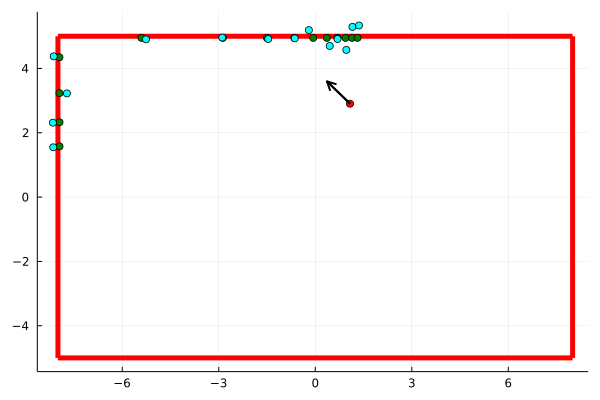

In [32]:
# Generate ground truth data from the model. The observations in this trace will be what we condition on
# and attempt to infer the pose.

wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

trace_ground_truth, w = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, 0.2));
viz_trace(trace_ground_truth)

In [33]:
# 1. Use Gen.regenerate to resample the poses in trace_ground_truth and do this 50000 times.
# So the result should be a list of 50000 traces with different poses sampled from the prior.

number_of_traces = 50000
# What I learnt is that Gen.regenrate allows the user to specify which parameters in the trace is to be re-sampled
# keeping the other parameters the same. 
candidate_traces = [
    Gen.regenerate(trace_ground_truth, Gen.select(:pose))[1] for i=1:number_of_traces
];
#########################################################################################################
# 50,000 traces takes me a very long time to run. I am unsure if this implementation is incorrect or it is normal 
# for the regeneration of 50,000 traces is supposed to take long. Hence I reduced the number by one order of
# magnitude.
#########################################################################################################
# 2. Get and normalize the scores (remember they are log score).
# This is the same implementation as in part 1
candidate_trace_scores = []
for candidate_trace in candidate_traces
    push!(candidate_trace_scores, Gen.get_score(candidate_trace))
end
norm_scores = exp.(candidate_trace_scores .- max(candidate_trace_scores...))
norm_scores = norm_scores ./ sum(norm_scores)

# 3. Visualize the poses with alpha (transparency) proportional to the weights using the snippet below
# This was quite simple for me, I just had to look through the candidate traces and apply the viz_pose function
# and use the alpha parameter with the weights (mormalized scores)
function viz_trace_alpha(trace_ground_truth, candidate_traces, weights)
    PL.plot()
    viz_env(;wall_colors=get_wall_colors(trace_ground_truth))
    for (i, trace) in enumerate(candidate_traces)
        viz_pose(get_pose(trace), alpha = weights[i])
    end
    viz_obs(trace_ground_truth)
    PL.plot!(aspect_ratio = 1)
end

viz_trace_alpha(trace_ground_truth, candidate_traces, norm_scores)
########################################################################################################
# With this naive inference approach, the agent is generally able to get close to the ground truth pose in the case
# of the 4-coloured walls. I can also tell that with "more" traces from the regeneration, the performance appears 
# to improve (by simply trying different values of the nuymber of traces). Another observation I have gathered is 
# that when I used walls of all the same color, I may get the wrong pose, but it is understandable form the perspective
# of the agent as the depth information is not enough. That being said, I face the same issue/mistake as in part 1 where
# the agent seems to be overconfident of one pose only , when it should consider multiple possible poses with relatively
# similar probabilities.
########################################################################################################

LoadError: InterruptException:

# Part 3 - Corner Detection

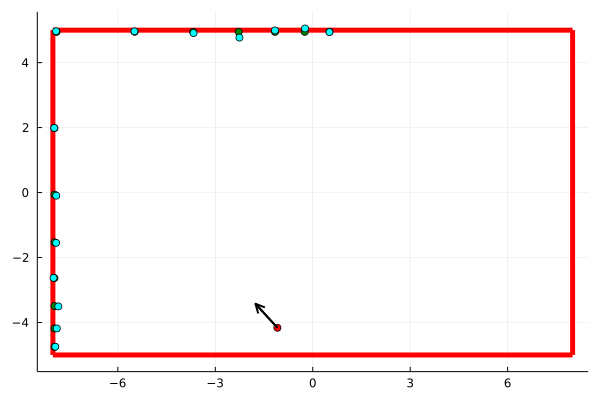

In [44]:
# Generate ground truth data from the model. The observations in this trace will be what we condition on
# and attempt to infer the pose.

wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

trace_ground_truth, w = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, 0.1));
viz_trace(trace_ground_truth)

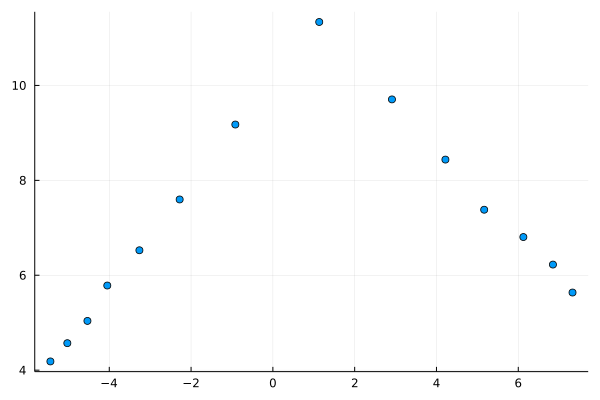

In [49]:
# We can take our observed depth map and convert it to a point cloud.
sense = get_sense_depth(trace_ground_truth)
cloud = GL.depth_image_to_point_cloud(reshape(sense,(camera_intrinsics.height, camera_intrinsics.width)), camera_intrinsics)
PL.scatter(cloud[1,:], cloud[3,:], label="")

In [50]:
# Write a function that takes this point cloud and finds the Pose of a corner (if it exists)
# Hint: The point cloud has a specific order that you can exploit. By looking at the differences
# between adjacent points, you can compute a "gradient" and find where the gradient changes significantly.

# Now, why did I say that we want to find the Pose of the corner? While the corner does have a position in space,
# it also has an orientation! We will assume that all corners for 90 degree angles. It is up to you how to
# define the orientation of the corner. But it will be a rotation of the form R.RotY(...)

############################################################################################################
# my solution to detecting the corner from the point cloud is to simply find any rapid corner change
# with a particular threshold. In this case I will set the threshold within 65 to 115 degrees
# I have noticed that this method fails rather miserably when it is very near to a corner or near to a flat wall
# I find it quite interesting as it reminds me how important it is for the early steps of such perception to 
# be accurate, as future steps are dependent on it. I noticed this because when this step of detecting corners
# does not work well, this error carries forward to the later heuristical step of finding 4 possible poses
############################################################################################################
function detect_corners_from_point_cloud(cloud)
    number_of_points = size(cloud,2)
    corner_poses = []
    for i=2:number_of_points-1
        # find the angle different between point 1 and 2 and point 2 and 3
        # first calculate the gradients
        grad_1_2 = (cloud[3,i] - cloud[3,i-1])/(cloud[1,i] - cloud[1,i-1])
        grad_2_3 = (cloud[3,i+1] - cloud[3,i])/(cloud[1,i+1] - cloud[1,i])
        # then find the angle difference with some basic geometry
        angle_diff = (180/pi)*abs(atan(grad_2_3) - atan(grad_1_2))
#         println(angle_diff)
        if angle_diff >= 65 && angle_diff <= 115
            # I will use the convention of setting a corner to 90 degrees (not sure what to do about this or what it means
            # as I dont use this later on)
            push!(corner_poses, P.Pose([cloud[1,i],cloud[2,i],cloud[3,i]], R.RotY(atan(pi/2))))
        end
    end
    return corner_poses
end

detect_corners_from_point_cloud (generic function with 1 method)

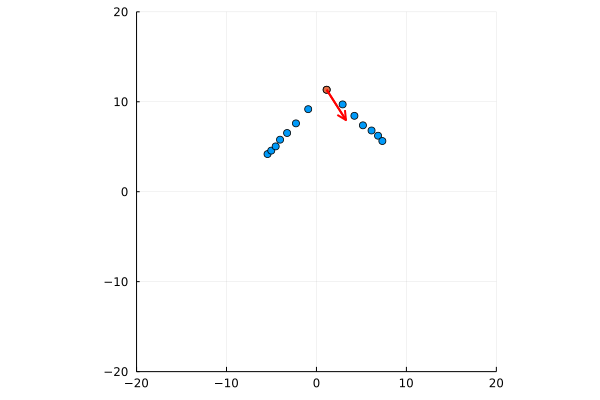

In [52]:
sense = get_sense_depth(trace_ground_truth)
cloud = GL.depth_image_to_point_cloud(reshape(sense,(camera_intrinsics.height, camera_intrinsics.width)), camera_intrinsics)

corners = detect_corners_from_point_cloud(cloud)

PL.scatter(cloud[1,:], cloud[3,:], label="")
for c in corners
    viz_corner(c)
end
PL.plot!(xlim=(-20,20),ylim=(-20,20), aspect_ratio=:equal, label="")

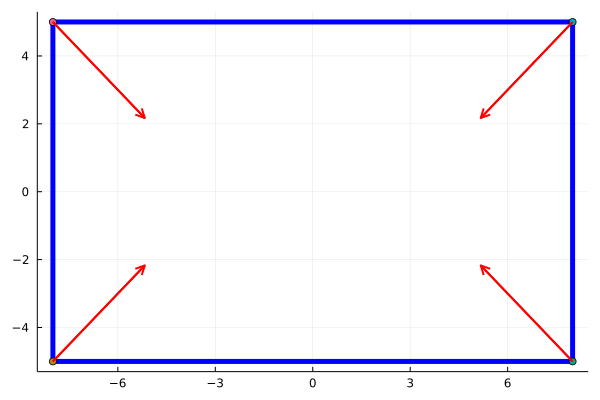

In [54]:
PL.plot()
viz_env()
corner_1 = P.Pose([room_width_bounds[1], 0.0, room_height_bounds[1]], R.RotY(-pi/4))
corner_2 = P.Pose([room_width_bounds[1], 0.0, room_height_bounds[2]], R.RotY(pi/4))
corner_3 = P.Pose([room_width_bounds[2], 0.0, room_height_bounds[1]], R.RotY(pi+pi/4))
corner_4 = P.Pose([room_width_bounds[2], 0.0, room_height_bounds[2]], R.RotY(pi-pi/4))
gt_corners = [corner_1,corner_2,corner_3,corner_4]
for c in gt_corners
    viz_corner(c)
end
PL.plot!()

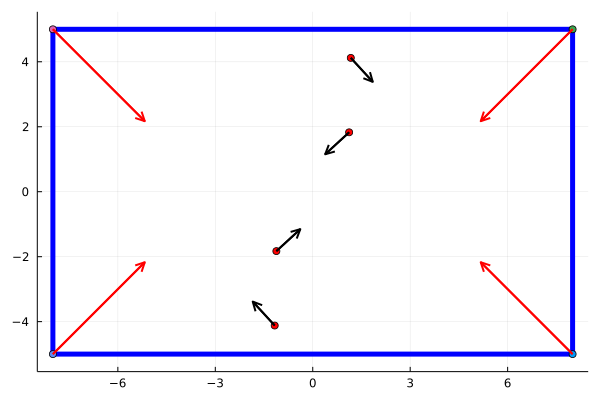

In [56]:
sense = get_sense_depth(trace_ground_truth)
cloud = GL.depth_image_to_point_cloud(reshape(sense,(camera_intrinsics.height, camera_intrinsics.width)), camera_intrinsics)
corners = detect_corners_from_point_cloud(cloud)

# Use the detected corners `corners` and the known map corneres `gt_corners`
# to back calculate the possilbe poses of the agent. This will requires some Pose math.

#############################################################################################
# Admittedly, this took me a longer time than I thought as I coded out the entire geometry manually
# along with some hardcoding. In hindsight, I think it is better to become familiar with Pose transformation
# and matrix transformation functions in Pose libraries. I am new to Julia, but I hope to pick up these
# skills with time. In the interest of time, I also did some hardcoding (e.g. having knowledge that gt_corners[1] 
# is the bottom left corner). For actual probabilistic robotics projects, I will avoid this habit.
#############################################################################################
poses = []
# simplification: assume there is only one corner detected (even if there are multiple)
# then there are up to 4 possible pose locations for the agent
if size(corners)[1] > 0
    corner = corners[1]
    depth = sqrt(corner.pos[1]^2 + corner.pos[3]^2)
    grad_after_corner = 0 # dummy initialization
    grad_to_corner = 0 # dummy initialization
    # find point after corner to determine gradient of line after corner
    number_of_points = size(cloud,2)
    for i=2:number_of_points-1
        if cloud[1,i] == corner.pos[1] && cloud[3,i] == corner.pos[3]
            grad_after_corner = (cloud[3,i+1] - cloud[3,i])/(cloud[1,i+1] - cloud[1,i])
            grad_to_corner = corner.pos[3]/corner.pos[1]
            break
        end
    end
    # now find the angle difference between line from agent to corner and the line of wall after corner
    # ensure angle is acute (<90 degrees)
    angle_diff = abs(atan(grad_after_corner) - atan(grad_to_corner))
    if angle_diff >= pi/2
        angle_diff = pi - angle_diff
    end
    # now determine the orientations based on the difference and depth
    # first get the angle beween forward direction and cornere
    angle_diff_2 = atan(grad_to_corner)
    if angle_diff_2 >= 0
        angle_diff_2 = pi/2 - angle_diff_2
    else
        angle_diff_2 = -1 * (pi/2 - abs(angle_diff_2))
    end    
    # now that we know the angle difference and depth, We can estimate the possible poses
    positions = []
    # bottom left corner
    push!(poses, P.Pose([depth*sin(angle_diff) + gt_corners[1].pos[1],0,depth*cos(angle_diff) + gt_corners[1].pos[3]],
        R.RotY(-pi + angle_diff - angle_diff_2)))
    # top left corner
    push!(poses, P.Pose([depth*cos(angle_diff) + gt_corners[2].pos[1],0,-1*depth*sin(angle_diff) + gt_corners[2].pos[3]],
        R.RotY(-pi/2 + angle_diff - angle_diff_2)))
    # bottom right corner
    push!(poses, P.Pose([-1*depth*cos(angle_diff) + gt_corners[3].pos[1],0,depth*sin(angle_diff) + gt_corners[3].pos[3]],
        R.RotY(pi/2 + angle_diff - angle_diff_2)))
    # top right corner
    push!(poses, P.Pose([-1*depth*sin(angle_diff) + gt_corners[4].pos[1],0,-1*depth*cos(angle_diff) + gt_corners[4].pos[3]],
        R.RotY(angle_diff - angle_diff_2)))
end

# ensure that only poses inside the map are considered (hence, filtered)
filtered_poses = []
for (i,pose) in enumerate(poses)
    if ! (pose.pos[1] > room_width_bounds[2] || pose.pos[1] < room_width_bounds[1] ||
        pose.pos[3] > room_height_bounds[2] || pose.pos[3] < room_height_bounds[1])
        push!(filtered_poses,pose)
    end
end
    
PL.plot()
viz_env()
for p in filtered_poses
   viz_pose(p) 
end
for c in gt_corners
   viz_corner(c) 
end
PL.plot!(aspect_ratio = 1)

##########################################################################################################################
# Assuming the earlier step of detecting corners works perfectly, this step appears to be generally accurate. The
# visualisation tends to show all 4 poses, or even 2 poses (if 2 of the 4 poses fall outside the map). When the pose
# falls out of the map, my code will filter it out automatically.
##########################################################################################################################

# Part 4 - Gaussian Distribution over Poses

In [57]:
struct PoseGaussian <: Gen.Distribution{P.Pose} end
const pose_gaussian = PoseGaussian()

# HINT: `R.RotY(center_pose.orientation).theta` will be useful to extract the head direction from the Pose
# You can then add Gaussian noise to head direction and position variables
function Gen.random(::PoseGaussian, center_pose::P.Pose, translation_covariance, head_dir_variance)
    #####################################################################################################################
    # NOTE: I am not treating the terms translation_covariance and head_dir_variance as the statistical definition
    # I am using it as a proportional measure of standard deviation. This is because I am not sure how I can disentangle
    # X and Z from a multivariate normal distribution
    #####################################################################################################################

    x = Gen.normal(center_pose.pos[1], translation_covariance)
    z = Gen.normal(center_pose.pos[3], translation_covariance)
    hd = Gen.normal(R.RotY(center_pose.orientation).theta, head_dir_variance)
    P.Pose([x, 0.0, z], R.RotY(hd))
end

# I am not sure if using the dot operator here is appropriate as it is not an array
function Gen.logpdf(::PoseGaussian, pose::P.Pose, center_pose::P.Pose, translation_covariance, head_dir_variance)
    (
        sum((x -> Gen.logpdf(Gen.normal, x, 0.0, translation_covariance)).(center_pose.pos[1] .- pose.pos[1])) +
        sum((x -> Gen.logpdf(Gen.normal, x, 0.0, translation_covariance)).(center_pose.pos[3] .- pose.pos[3])) +
        sum((x -> Gen.logpdf(Gen.normal, x, 0.0, head_dir_variance)).(R.RotY(center_pose.orientation).theta .- R.RotY(pose.orientation).theta))
    )
end

In [58]:
# Mixture over poses
mixture_of_pose_gaussians = Gen.HomogeneousMixture(pose_gaussian, [0, 2, 0])

@Gen.gen function pose_mixture_proposal(trace, poses, translation_covariance, head_dir_variance)
    n = length(poses)
    weights = ones(n) ./ n
    {pose_addr()} ~ mixture_of_pose_gaussians(
        weights, poses, cat([cov for _ in 1:n]..., dims=3), [var for _ in 1:n]
    )
end

Gen.DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing], var"##pose_mixture_proposal#315", Bool[0, 0, 0, 0], false)

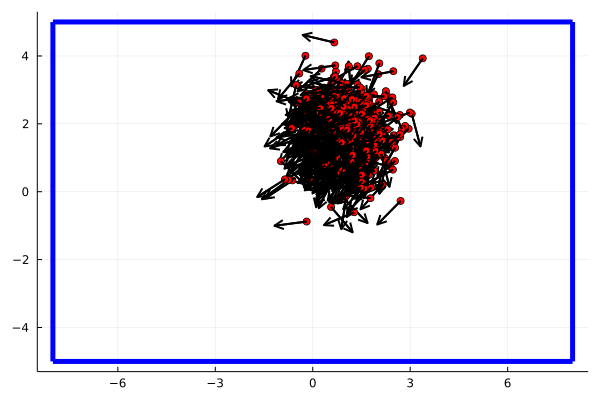

In [59]:
PL.plot()
viz_env()

# Sample from the PoseGaussian using Gen.random
sampled_poses = [ # I am using a random pose from part 3
    Gen.random(pose_gaussian, filtered_poses[1], Gen.uniform(0,1), Gen.uniform(0,1)) for i=1:1000
]


for p in sampled_poses
   viz_pose(p)
end
PL.plot!()
###################################################################################################
# This is quite interesting when I vary the range of values of the variances using a uniform distribution.
# When I reduce the range of translational covariance, the size of the cluster becomes smaller. When I 
# reduce the size of the heading variance, the arrows tends to point more into the same direction. This is all
# expected.
###################################################################################################

# Part 5 - Custom Proposal

In [248]:
# Use Gen.metropolis_hastings with a custom proposal to do faster inference in the SLAM model.

# The custom proposal will be `pose_mixture_proposal` with the `poses` being the list of 4 poses
# computed by your corner detection + Pose back calculation.

    # FILL ME IN
###############################################################################################################
# Nishad mentioned that this section is a lot harder and requires more familiarity with Gen, and that it is
# okay to skip. As I still am new to Gen, I am not entirely sure how to write a custom propocal. In the interest of time
# I have decided to skip this step. However, I do wish to come back to this another day and complete it.
# I think it would be helpful to me if one could explain how to create a proposal distribution in Gen, so that I
# can attempt this part.
###############################################################################################################

# Part 6 - Parameter Exploration

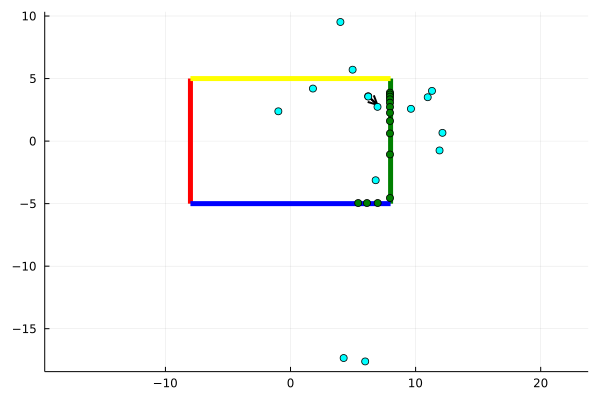

In [245]:
# Change the value of `depth_likelihood_variance` and investigate how this changes properties of the posterior.
# You can inspect the posterior using the enumeration procedure you wrote in part 1.

wall_colors = [I.colorant"red",I.colorant"green",I.colorant"blue",I.colorant"yellow"]
# wall_colors = [I.colorant"red",I.colorant"red",I.colorant"red",I.colorant"red"]

depth_likelihood_variance = 10
trace_ground_truth, w = Gen.generate(slam_model, (room_width_bounds, room_height_bounds, wall_colors, depth_likelihood_variance));
viz_trace(trace_ground_truth)

############################################################################################################
# So I have completed this part by varying the depth_likelihood_variance. The salient observation is that 
# higher variance means that the observations are more scattered and noisy (like many real sensors). With a variance
# as low as 0.001, the observations are neglibily perfect and hence Parts 1 and 2 perform well (as expected). But when
# I increase the varaince to a ridiculously high value like 10, the agent starts becoming uncertain about the robot
# pose. Even for part 2, the agent becomes uncertain. Below this cell, there are 3 images 
# (ground truth, pose from part 1 and pose from part 2) which all show the case when the variance is extremely high at 10.
# this shows that even in simple scenarios, we cannot afford to have overly-noisy data when determining the posterior
# for the agent's pose.
############################################################################################################

## 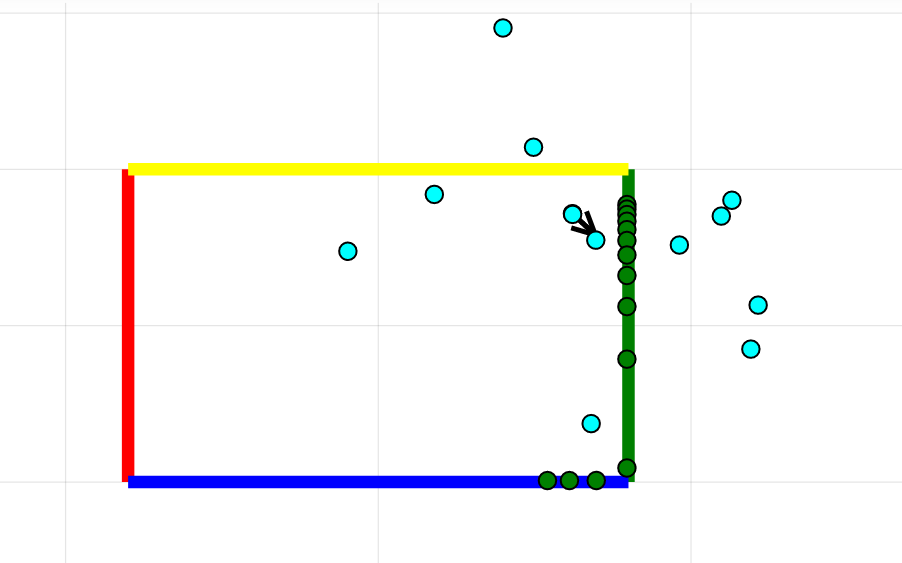

# 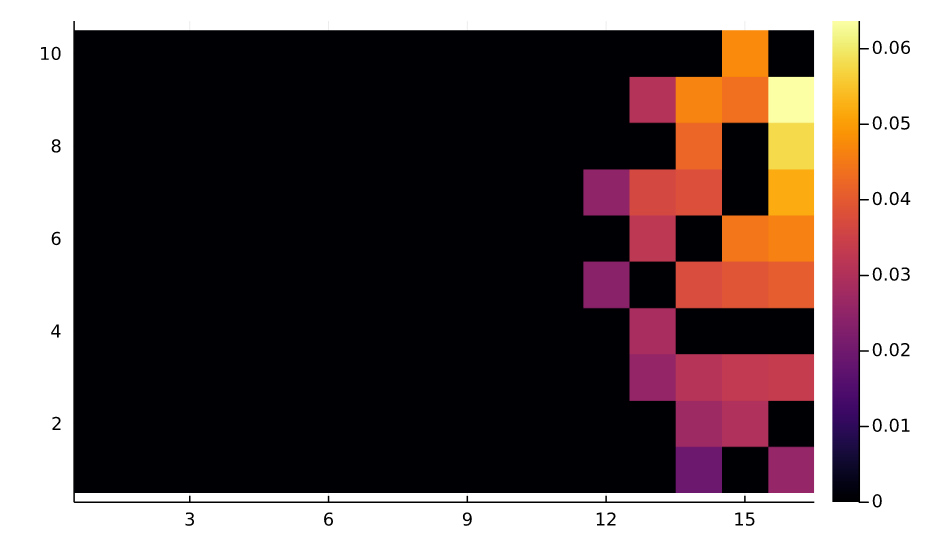

# 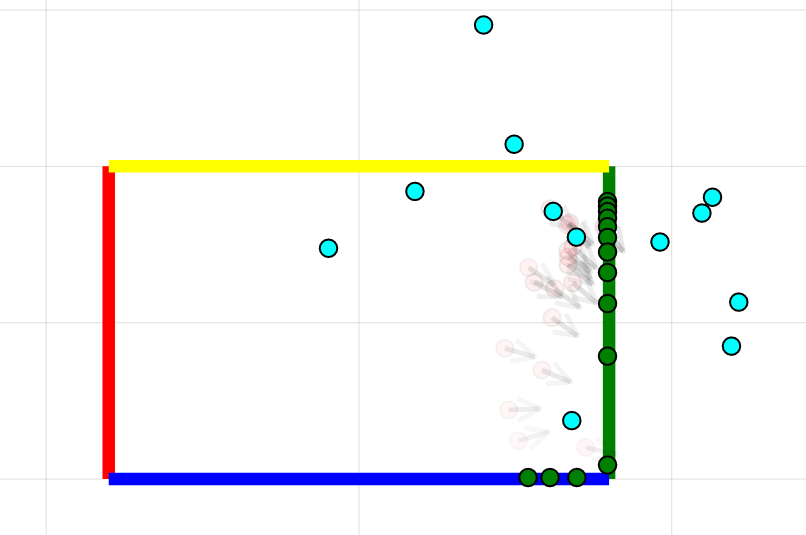

# Part 7 - Next Steps

This exercise, while being relatively simple as compared to real robotic applications, has taught me a lot about probabilistic programming and how it can be applied to tasks in robotics. I can see how the problems of robotics (task-completion, localization & mapping (SLAM), path-planning, sensor fusion, human-robot collaboration) can be modelled via a probabilistic framework. Given the general limitation of deep learning methods in its ability to generalize, I can see how modelling parameters with uncertainty allows probabilistic systems to be flexible in making choices. For instance in modelling objects with vision, we can model the probability distribution of an object's location. Given priors of the previous states, this will allow one to expect an object to be present, even when occluded from view. In human-robot collaboration, robotic systems will need to have an idea of human cognition. An area where this can be relevant is in social situations (e.g. an infant-companion robot inferring the emotions of an infant via facial expression and audio which can be used to decide on the appropriate subsequent action). There could be countless of such examples. I hope to deepen my knowledge on probabilistic programming and use it in real tasks, so I can fully appreciate its potential to increase data efficiency, generalization and robustness. I am excited for the next steps!